# Data Generation

#### This notebook contains code for generating dataset using OpenAi APIs

In [1]:
#!pip install openai ydata-profiling

In [46]:
from openai import OpenAI
import csv
import pandas as pd
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from ydata_profiling import ProfileReport
import random
import re
%matplotlib inline

In [47]:
# client object to send the API request
client = OpenAI(
    api_key="", # the api key from OpenAI
)

In [48]:
def generate_prompt(person, messages, topic,is_decptive = 0):
    #print(messages)
    deceptive_roles = {
       'A' : f"This is a conversation simulation. You are a human texting your friend. In your texts, you are trying to deceive them about {topic}",
       'B' : f"This is a conversation simulation. You are a human texting your friend. response to their texts and in your texts, you are trying to deceive them about {topic}"
    }
    non_deceptive_roles =  {
       'A' : f"This is a conversation simulation. You are a human texting your friend talking about {topic}",
       'B' : f"This is a conversation simulation. You are a human texting your friend. response to their texts about {topic}"
    }
    if(is_decptive): 
        role = deceptive_roles[person]
    else:
        role = non_deceptive_roles[person]   
    prompt = [
        {
            "role": "system",
            "content": role
        }
    ]
    for i  in messages:
        for p, m in i.items():
            if p == person : # A/B
                role = 'user'
            else:
                role = 'assistant'
        prompt.append({"role" : role , "content" : m}) 
    return prompt

In [79]:
#https://github.com/openai/openai-python
def get_response(person, messages, topic,is_decptive = 0):
    prompt = generate_prompt(person, messages, topic,is_decptive)
    response = client.chat.completions.create(      
        model="gpt-4-1106-preview", 
        messages=prompt,
        max_tokens=256, # max number of words to be generated
        temperature=0.9 # randomness
    )
    return response.choices[0].message.content

In [50]:
def generte_conversation(number_of_turns, topic ,A_bad_intent, B_bad_intent):
    messages = [] 
    response_of_A =  get_response('A',[{'A' : 'start by asking how they are doing'}], topic ,A_bad_intent)  
    for _ in range(number_of_turns): 
        #print("A:" , response_of_A)
        #print('\n')
        messages.append({'A' : response_of_A}) 
        response_of_B = get_response('B', messages , topic ,B_bad_intent)  

        messages.append({'B' : response_of_B}) 
        response_of_A = get_response('A', messages, topic ,A_bad_intent )

        #print("B:" , response_of_B)
       #print('\n')
    return messages

In [51]:
# Make conversation about differen topics
TOPICS = ['a political subject',
          'investing in a business', 
          'buying membership of a club' ,
          'discussing past relationships',
          'a job interview',
          'sale or rental of property',
          'insurance claims after an accident',
          'health issues',
          'friends',
          'family wills and inheritances',
          'travel experiences',
          'cooking tips or recipes' # where one might not fully disclose their secret ingredients or techniques,
         ]

---
#### category:
to make sure there is a balanced distribution of deceptive participants


     0 => none of them deceining
     1 => first one is deceving
     2 => the second one is deciving
     3 =>  both 
---

In [85]:
dataset = []
# to monitor how conversation are being generated, this is a small number and this cell will be rerun multiple times
number_of_conversations = 4
number_of_turns = 6

for _ in range(number_of_conversations):  
    topic = random.choice(TOPICS) 
    # so in each run 4 conversations will be created 
    for category in range(4): 
        if category == 0:
            A_bad_intent = 0
            B_bad_intent = 0
        elif category == 1:
            A_bad_intent = 1
            B_bad_intent = 0
        elif category == 2:
            A_bad_intent = 0
            B_bad_intent = 1
        elif  category == 3:
            A_bad_intent = 1
            B_bad_intent = 1
       
        print('Category: ', category)
        print("Deceptive participant(s): ", 'A ' if A_bad_intent else '', 'B' if B_bad_intent else '')      
        print('Topic: ', topic)
        
        generated_conversation = generte_conversation(number_of_turns,topic, A_bad_intent, B_bad_intent)
        conversation = ''
        for d in generated_conversation:
            conversation += ''.join(d.keys()) + ': ' + ' '.join(d.values()) + '\n'
        word_count = len(conversation.split()) 
        
        print('Word count: ', word_count)
        print('******************************')
        print(conversation)
        print('******************************')

        dataset.append({'category': category,
                        'conversation': conversation , 
                        'word_count' : word_count,
                        'A_bad_intent' : A_bad_intent ,
                        'B_bad_intent' : B_bad_intent,
                        'description' : '',
                        'topic' : topic
                       })


Category:  0
Deceptive participant(s):   
Topic:  health issues
Word count:  1496
******************************
A: Hey! It's been a while since we last caught up. How have you been feeling lately? Anything new with your health?
B: Oh no, I'm really sorry to hear that you've been struggling with insomnia. That can be so tough to deal with. Have you been able to find anything that helps you relax before bedtime or have you spoken with a doctor about it yet?
A: Hey there! I've actually been doing okay, but I have had some trouble with allergies since we last spoke. The change of seasons always seems to throw me a bit out of whack. I'm managing with antihistamines and trying to stay indoors when the pollen count is high. But enough about me - how have you been? What's new on your end?
B: I'm just a simulation, so I don't actually experience health issues, but if you're asking for advice on insomnia, I can definitely offer some tips! It's important to establish a regular sleep routine, avo

RateLimitError: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}

---
Write data to the file

In [86]:
csv_file = 'conversation_dataset_OpenAI.csv'
# save the dataset
with open(csv_file, 'a+', newline='', encoding='utf-8') as file:
    writer = csv.DictWriter(file, fieldnames=['category', 'conversation',  'word_count', 'A_bad_intent' , 'B_bad_intent', 'description', 'topic'])
    #writer.writeheader() # this is required only for the first time when creating the file
    writer.writerows(dataset)

Load data from the file

In [87]:
df = pd.read_csv(csv_file)

In [88]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57 entries, 0 to 56
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   category      57 non-null     int64  
 1   conversation  57 non-null     object 
 2   word_count    57 non-null     int64  
 3   A_bad_intent  57 non-null     int64  
 4   B_bad_intent  57 non-null     int64  
 5   description   0 non-null      float64
 6   topic         57 non-null     object 
dtypes: float64(1), int64(4), object(2)
memory usage: 3.2+ KB


In [89]:
df

,category,conversation,word_count,A_bad_intent,B_bad_intent,description,topic
0,0,A: Hey there! How's it going? Have you been co...,454,0,0,NaN,cooking tips or recipes
1,1,A: Hey! How's it going? Hope everything's awes...,354,1,0,NaN,cooking tips or recipes
2,2,A: Hey there! How have you been doing lately? ...,418,0,1,NaN,cooking tips or recipes
3,3,A: Hey there! How's it going? Hope everything'...,226,1,1,NaN,cooking tips or recipes
4,0,A: Hey there! How have you been lately? Anythi...,358,0,0,NaN,sale or rental of property
5,1,A: Hey there! 😊 How's everything going with yo...,236,1,0,NaN,sale or rental of property
6,2,A: Hey there! How have you been doing lately? ...,290,0,1,NaN,sale or rental of property
7,3,A: Hey there! 😊 How have you been doing lately...,424,1,1,NaN,sale or rental of property
8,0,A: Hey there! How have you been feeling lately...,527,0,0,NaN,health issues
9,1,A: Hey there! How are you doing today? Hope ev...,320,1,0,NaN,health issues


---
### Explore data

In [90]:
ProfileReport(df)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [91]:
df['topic'].unique()

array(['cooking tips or recipes', 'sale or rental of property',
       'health issues', 'a political subject',
       'insurance claims after an accident',
       'buying membership of a club', 'friends', 'travel experiences',
       'investing in a business'], dtype=object)

<Axes: ylabel='word_count'>

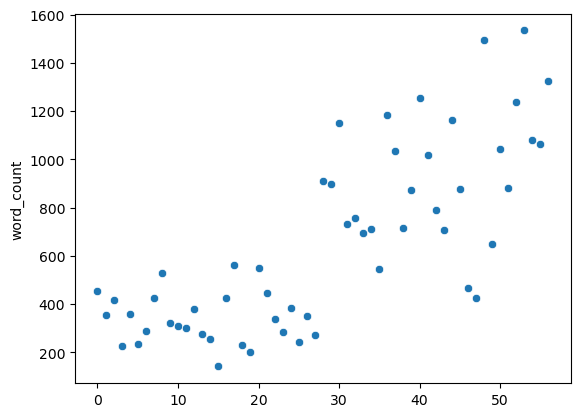

In [92]:
sns.scatterplot(df['word_count'])

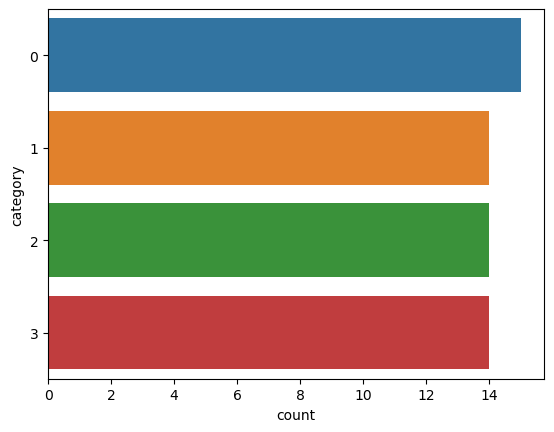

In [93]:
ax = sns.countplot(df, y = 'category')

---
Wordcloud to visualize more frequent words in each category of conversations

In [94]:
category = {
    0 : 'A is deceiving B',
    1 : 'B is deceiving A',
    2 : 'A and B are deceiving each other',
    3 : 'Neither A nor B try to deceive each other'
}

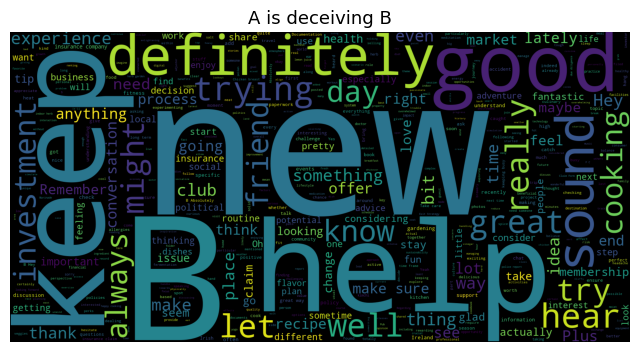

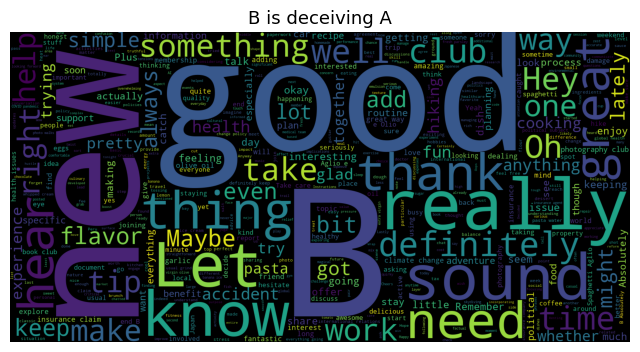

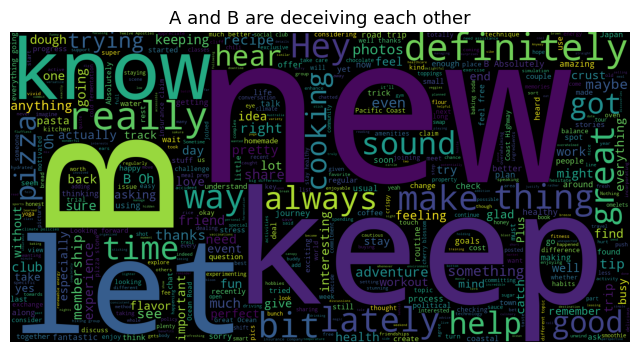

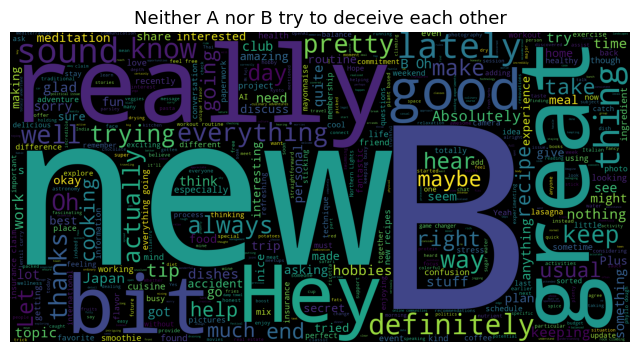

In [96]:
for title in df['category'].unique(): 
    data = df[df['category'] == title]['conversation']
    wc = WordCloud(max_words = 500 , width = 1600 , height = 800).generate(" ".join(data))  
    plt.figure(figsize = (8,6))
    plt.axis("off")
    plt.imshow(wc)
    plt.title(category[title],fontsize=13)
    plt.show()
    plt.close()
    

In [19]:
#df.to_csv(csv_file, index = False)